### **RNN (WITH 25 EPOCHS AND 320 BATCH)**
-BASE MODELS to later compare in notebook 2 with LSTM y GRU



### Import Required Libraries

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


### Read Data

Our data is a text file of English-Spanish sentence pairs. First we will read the file using the function defined below.

In [0]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-Spanish pairs separated by '\n' and then split these pairs into English sentences and Spanish sentences.

In [0]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

Mount your drive:

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to code directory
%cd /content/drive/My Drive/NLP_Julia

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/NLP_Julia


In [0]:
data = read_text("spa-eng/spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)[:,0:2] #NOS QUEDAMOS SOLO CON LAS PRIMERAS COLUMNAS QUE TIENEN LA INFORMACION

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [0]:
spa_eng = spa_eng[:50000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [7]:
spa_eng

array([['Go.', 'Ve.'],
       ['Go.', 'Vete.'],
       ['Go.', 'Vaya.'],
       ...,
       ['I am waiting for my driver.', 'Estoy esperando a mi chofer.'],
       ['I appreciate all your help.', 'Aprecio toda tu ayuda.'],
       ['I appreciate your interest.', 'Agradezco tu interés.']],
      dtype='<U332')

We will get rid of the punctuation marks, and then convert the text to lower case.

#### *IMPORTANTE QUITAR LA EXCLAMACION HACIA ARRIBA PARA EL ESPAÑOL



In [0]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

## TAMBIEN QUITAMOS ESTA EXCLAMACION QUE LO ANTERIOR NO LO QUITA
spa_eng[:,0] = [s.translate(str.maketrans('', '', '¡')) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', '¡')) for s in spa_eng[:,1]]

# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    
    spa_eng[i,1] = spa_eng[i,1].lower()

In [9]:
spa_eng

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ...,
       ['i am waiting for my driver', 'estoy esperando a mi chofer'],
       ['i appreciate all your help', 'aprecio toda tu ayuda'],
       ['i appreciate your interest', 'agradezco tu interés']],
      dtype='<U332')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and Spanish, respectively.

In [0]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [11]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.spa))

       eng  spa
0        1    1
1        1    1
2        1    1
3        1    1
4        1    1
...    ...  ...
49995    6    5
49996    8    6
49997    6    5
49998    5    4
49999    4    3

[50000 rows x 2 columns]
8
12


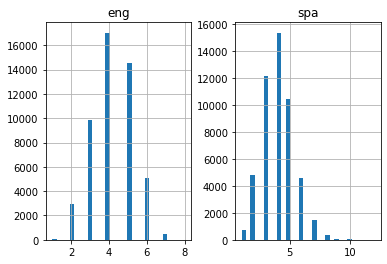

In [12]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the Spanish sentences is 12 and that of the English phrases is 8.


Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [0]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [14]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6942


In [15]:
# prepare Spanish tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 13937


In [0]:
#print(spa_tokenizer.word_counts)

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode Spanish sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [19]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[   1   10 1574 ...    0    0    0]
 [4805    4    6 ...    0    0    0]
 [  14 4930    0 ...    0    0    0]
 ...
 [  43  198 1663 ...    0    0    0]
 [  18   12   15 ...    8 1195    0]
 [   2  241 1477 ...    0    0    0]]
40000
[[   3  182   10 ...    0    0    0]
 [   1 1094    6 ...    0    0    0]
 [  50  101    9 ...    0    0    0]
 ...
 [  44  444  432 ...    0    0    0]
 [  22    4  123 ...  213    0    0]
 [   1  202 2244 ...    0    0    0]]
40000


In [20]:
print(trainX.shape)
print(trainY.shape)

(40000, 8)
(40000, 8)


In [21]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[  53   43   30 ...    0    0    0]
 [ 235    4    1 ...    0    0    0]
 [ 107 8429    0 ...    0    0    0]
 ...
 [9404  115  975 ...    0    0    0]
 [1347   55  598 ...    0    0    0]
 [   2   32 6681 ...    0    0    0]]
10000
[[  36   16   40 ...    0    0    0]
 [   1   37    3 ...    0    0    0]
 [   2   99 1339 ...    0    0    0]
 ...
 [  56 1781   29 ...    0    0    0]
 [  33    2  217 ...    0    0    0]
 [   1  867   42 ...    0    0    0]]
10000


In [22]:
print(testX.shape)
print(testY.shape)

(10000, 8)
(10000, 8)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an RNN layer as our encoder and another RNN layer followed by a Dense layer as the decoder.  


In [0]:
# build NMT model (RNN)
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(SimpleRNN(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(SimpleRNN(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [24]:
print(spa_vocab_size)
print(eng_vocab_size)
print(spa_length)
print(eng_length)

13937
6942
8
8


In [0]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 25 epochs and with a batch size of 320. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [26]:
filename = 'modelRNN.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=25, batch_size=320, #512 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/25
32000/32000 [==============================] - 5s 158us/step - loss: 3.5486 - val_loss: 3.1689

Epoch 00001: val_loss improved from inf to 3.16893, saving model to modelRNN.h1
Epoch 2/25
32000/32000 [==============================] - 4s 135us/step - loss: 3.0459 - val_loss: 2.9638

Epoch 00002: val_loss improved from 3.16893 to 2.96384, saving model to modelRNN.h1
Epoch 3/25
32000/32000 [==============================] - 4s 135us/step - loss: 2.8529 - val_loss: 2.7877

Epoch 00003: val_loss improved from 2.96384 to 2.78769, saving model to modelRNN.h1
Epoch 4/25
32000/32000 [==============================] - 4s 135us/step - loss: 2.6351 - val_loss: 2.6303

Epoch 00004: val_loss improved from 2.78769 to 2.63031, saving model to modelRNN.h1
Epoch 5/25
32000/32000 [==============================] - 4s 134us/step - loss: 2.4310 - val_loss: 2.5754

Epoch 00005: val_loss improved from 2.63031 to 2.57537, saving model to modelRNN.h1


Let's compare the training loss and the validation loss.

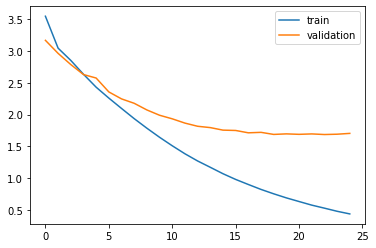

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [28]:
model = load_model('modelRNN.h1')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [0]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'Spanish':  test[:,1], 'actual traduction' : test[:,0], 'predicted' : preds_text})

In [0]:
pd.set_option('display.max_colwidth', 200)

In [33]:
pred_df.head(15)

,Spanish,actual traduction,predicted
0,ellos son muy optimistas,they are very cheerful,they are dangerous
1,conozco a tom,i know tom,i know tom
2,puedes negarte,you may refuse,you can it
3,eso es privado,thats private,thats is
4,tom saltó desde su asiento,tom leaped from his seat,tom held his
5,¿jamás has vendido un auto,have you ever sold a car,have you ever a car
6,¿cuántos hijos tienes,how many kids do you have,how many kids do you have
7,no te dejaré hacerlo,i will not let you do it,i wont get to it
8,¿no es hermoso,isnt it beautiful,isnt you beautiful
9,mi loro murió ayer,my parrot died yesterday,my uncle was yesterday


In [34]:
pred_df.sample(15)

,Spanish,actual traduction,predicted
7741,trabajar solo no es divertido,working alone is no fun,tom isnt hard
7871,bajá un cambio,calm down,there a pen
2901,esto es muy grande,this is really big,this is very big
4351,date prisa tom,hurry up tom,hurry up tom
8802,tom está esperando al teléfono,tom is on hold,tom is over the
2639,empieza a escribir,start writing,start started
5684,estoy muy cachondo,im very hot,im very
121,¿cómo suena eso,how does that sound,how that do
9748,esta muñeca tiene ojos grandes,this doll has big eyes,this has have nice
9801,tom no me lo dijo,tom didnt tell me,tom didnt believe that


This simple model already translates some phrases correctly (phrase 4827 o 1)! Nevertheless, it makes many mistakes and should be deeply optimized